# Assignment 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time

from data_rnn import load_ndfa

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.distributions as dist

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

device

device(type='cpu')

### Load data

In [4]:
# NDFA
x_train, (i2w, w2i) = load_ndfa(n=150_000)

# # Brackets
# x_train, (i2w, w2i) = load_brackets(n=150_000)

In [5]:
len(x_train)

150000

In [6]:
x_train[0]

[10, 10]

In [7]:
print(''.join([i2w[i] for i in  x_train[10_000]]) )

ss


In [8]:
vocab_size = len(w2i)
vocab_size

15

In [9]:
w2i

{'.pad': 0,
 '.start': 1,
 '.end': 2,
 '.unk': 3,
 'b': 4,
 'w': 5,
 'c': 6,
 'k': 7,
 'a': 8,
 'm': 9,
 's': 10,
 '!': 11,
 'u': 12,
 'l': 13,
 'v': 14}

In [10]:
def get_max_seq_length(batch):
    return max(len(seq) for seq in batch)

In [11]:
def get_sum_seq_lengths(batch):
    return sum(len(seq) for seq in batch)

In [12]:
def add_padding(seq, amt=1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [13]:
def add_start(seq):
    seq.insert(0, w2i['.start'])
    return seq

In [14]:
def add_end(seq):
    seq.append(w2i['.end'])
    return seq

In [15]:
print(f'The longest sequence in trainset has {get_max_seq_length(x_train)} length.')

The longest sequence in trainset has 158 length.


In [16]:
print(f'Mean length of a sequence in trainset is {get_sum_seq_lengths(x_train) / len(x_train)}.')

Mean length of a sequence in trainset is 13.96264.


In [17]:
def preprocess_batch(batch):
    max_len = get_max_seq_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt=max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype=torch.long)
    return upd_batch

In [18]:
def get_batches(data, max_token_amount=10000):
    batches, targets = [], []
    bound_l, bound_r = -1, 0

    while bound_r < len(data):
        bound_l = bound_r

        num_of_tokens = 0
        while bound_r < len(data) and (num_of_tokens + len(data[bound_r])) < max_token_amount:
            num_of_tokens += len(data[bound_r])
            bound_r += 1
        print(bound_l, bound_r)
        batch = data[bound_l:bound_r]
        batch = preprocess_batch(batch)
        target = F.pad(batch, (0, 1), "constant", 0)[:, 1:]
        # target = F.one_hot(target, num_classes=vocab_size)

        batches.append(batch)
        targets.append(target)
    return batches, targets


In [19]:
def batch_generator(batches, targets):
    indices = list(range(len(batches)))
    random.shuffle(indices)
    # print(f'Shuffle: {indices}')
    
    for ind in indices:
        yield batches[ind], targets[ind], (len(batches[ind]), len(batches[ind][0]))

## Question 5

In [20]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size=32, hidden_size=16, lstm_num_layers=3) -> None:
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, lstm_num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        x = input
        x = self.embed(x)
        x, (hn, cn) = self.lstm(x)
        output = self.linear(x)
        return output

In [21]:
net = Net(vocab_size)
net

Net(
  (embed): Embedding(15, 32)
  (lstm): LSTM(32, 16, num_layers=3, batch_first=True)
  (linear): Linear(in_features=16, out_features=15, bias=True)
)

In [27]:
def train(model, batches, targets, epochs=3, learning_rate=0.01, device=torch.device('cpu')):
    criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=w2i['.pad'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    metrics = {
        'loss_history': [], # loss per iteration
        'loss_train': [], # loss per epoch
        'loss_history_per_token': [] # loss per token on iteratiom
    }

    total_loss = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")

        for i, (x_batch, y_batch, batch_len) in enumerate(batch_generator(batches, targets)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            assert x_batch.shape == y_batch.shape
            # print(x_batch[0], y_batch[0])

            optimizer.zero_grad()

            start_time = time()
            outputs = model(x_batch)
            loss = criterion(outputs.reshape(outputs.shape[0]*outputs.shape[1], -1), y_batch.reshape(y_batch.shape[0]*y_batch.shape[1], )) # outputs: [batch_size*time, vocab_size], y:[batch_size*time]
            loss.backward()
            finish_time = time()

            # print statistics
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / y_batch.size()[0] / y_batch.size()[-1]:.6f} time: {finish_time - start_time:.3f}')
            metrics['loss_history_per_token'].append(loss.item() / y_batch.size()[0] / y_batch.size()[-1]) # loss per token for each iteration
            metrics['loss_history'].append(loss.item())
            total_loss.append(loss.item())

            optimizer.step()

        metrics['loss_train'].append(np.mean(total_loss)) # mean loss per epoch
    return model, metrics

In [28]:
vocab_size=len(w2i)
max_token_amount = 50000


embedding_size = 32
hidden_size = 16
lstm_num_layers = 1

epochs = 3
learning_rate = 0.01

In [29]:
batches, targets = get_batches(x_train, max_token_amount=max_token_amount)
print(len(batches))

0 24999
24999 41610
41610 49943
49943 58276
58276 66236
66236 71235
71235 76234
76234 81233
81233 86232
86232 89943
89943 93514
93514 97085
97085 100656
100656 103883
103883 106660
106660 109437
109437 112214
112214 114903
114903 117175
117175 119447
119447 121719
121719 123905
123905 125828
125828 127751
127751 129674
129674 131394
131394 133060
133060 134726
134726 136236
136236 137706
137706 139135
139135 140450
140450 141759
141759 142949
142949 144108
144108 145194
145194 146203
146203 147149
147149 148027
148027 148816
148816 149512
149512 150000
42


In [30]:
batches[0][:5], targets[0][:5]

(tensor([[ 1, 10, 10,  2],
         [ 1, 10, 10,  2],
         [ 1, 10, 10,  2],
         [ 1, 10, 10,  2],
         [ 1, 10, 10,  2]]),
 tensor([[10, 10,  2,  0],
         [10, 10,  2,  0],
         [10, 10,  2,  0],
         [10, 10,  2,  0],
         [10, 10,  2,  0]]))

In [31]:
model = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)
model, metrics = train(model, batches, targets, epochs, learning_rate, device)

Epoch 1
-------------------------------
[1,     1] loss: 2.629756 time: 0.212
[1,     2] loss: 2.451179 time: 0.152
[1,     3] loss: 2.330926 time: 0.119
[1,     4] loss: 2.266205 time: 0.095
[1,     5] loss: 1.468756 time: 0.166
[1,     6] loss: 2.053754 time: 0.115
[1,     7] loss: 2.029179 time: 0.172
[1,     8] loss: 1.793088 time: 0.199
[1,     9] loss: 1.971679 time: 0.212
[1,    10] loss: 1.787137 time: 0.189
[1,    11] loss: 1.794798 time: 0.112
[1,    12] loss: 1.761398 time: 0.118
[1,    13] loss: 1.478545 time: 0.114
[1,    14] loss: 1.583803 time: 0.114
[1,    15] loss: 1.508735 time: 0.116
[1,    16] loss: 0.927355 time: 0.251
[1,    17] loss: 1.351821 time: 0.127
[1,    18] loss: 1.393423 time: 0.191
[1,    19] loss: 1.239339 time: 0.098
[1,    20] loss: 1.207376 time: 0.112
[1,    21] loss: 1.180923 time: 0.113
[1,    22] loss: 1.095127 time: 0.119
[1,    23] loss: 1.078314 time: 0.110
[1,    24] loss: 0.988235 time: 0.116
[1,    25] loss: 0.974649 time: 0.109
[1,    26]

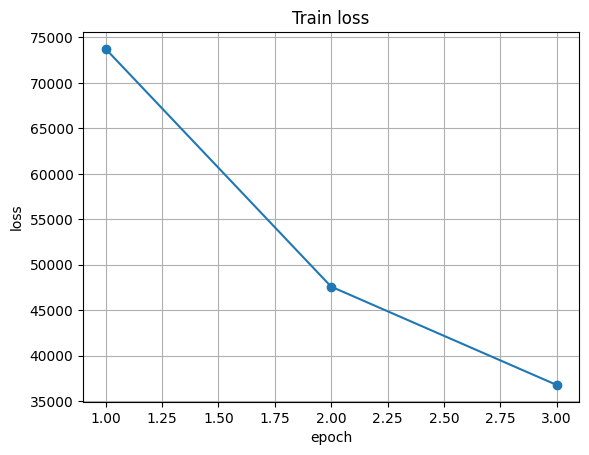

In [32]:
plt.plot(range(1, epochs + 1), metrics['loss_train'], marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

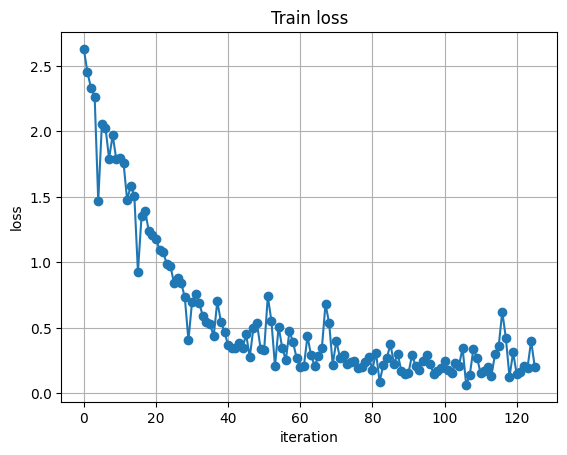

In [33]:
plt.plot(metrics['loss_history_per_token'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

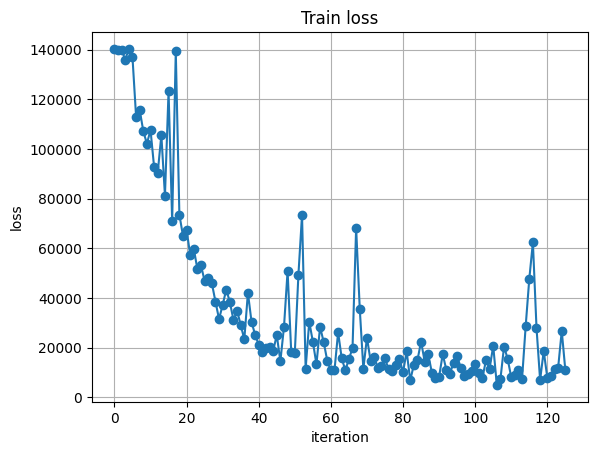

In [34]:
plt.plot(metrics['loss_history'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()